In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm

Importing Data

Model 1: CNN

In [4]:

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model = Sequential()
model.add(Conv2D(512, (3, 3), input_shape=(63, 64, 3)))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())

model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Dropout(0.25))
model.add(Dense(37))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=[root_mean_squared_error])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 512)       14336     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 256)       1179904   
_________________________________________________________________
activation (Activation)      (None, 60, 60, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       295040    
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 128)      

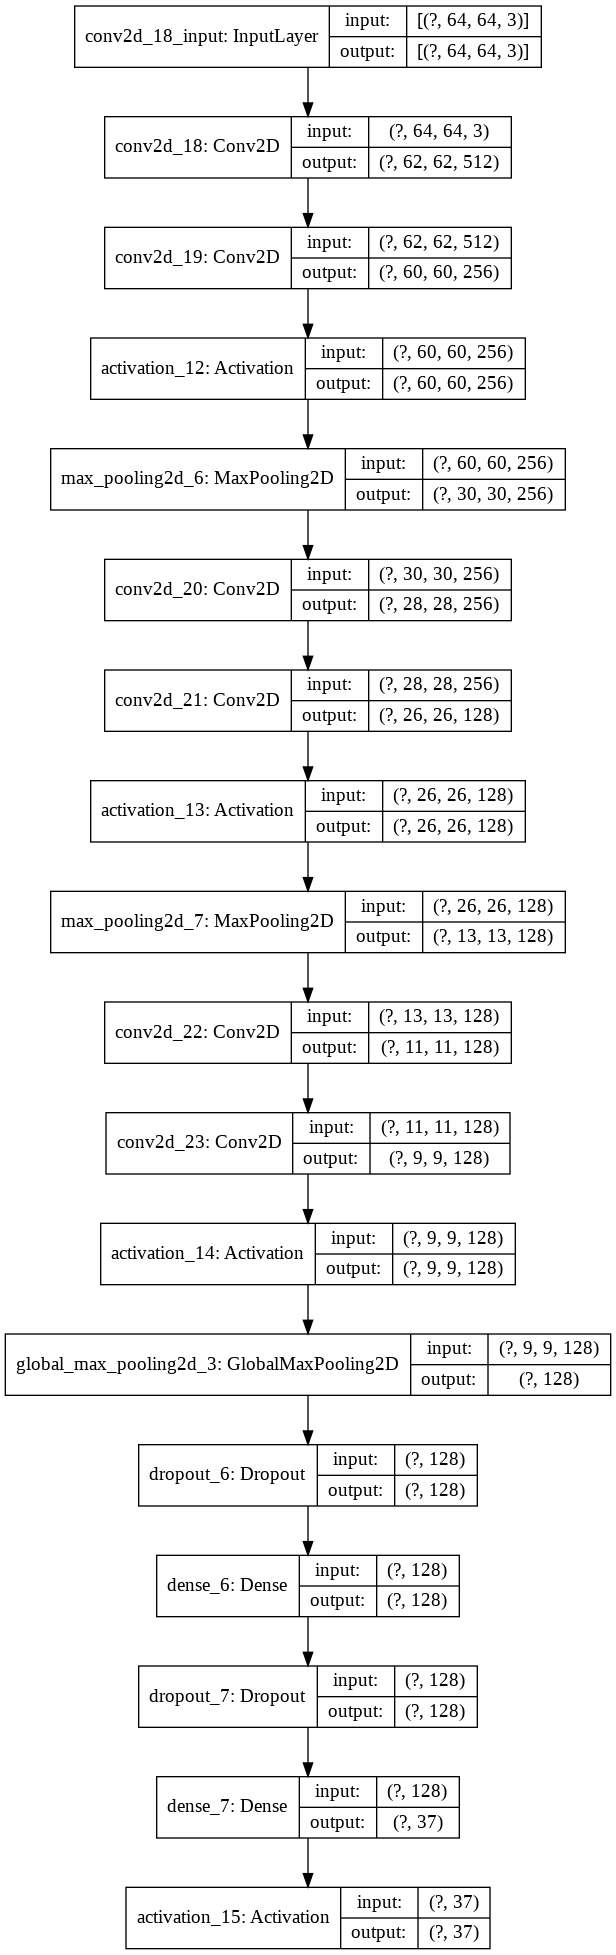

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='vgg_block.png')

Model 2: ResNet


Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 64, 64, 64)   1792        input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_42[0][0]                  
______________________________________________________________________________________

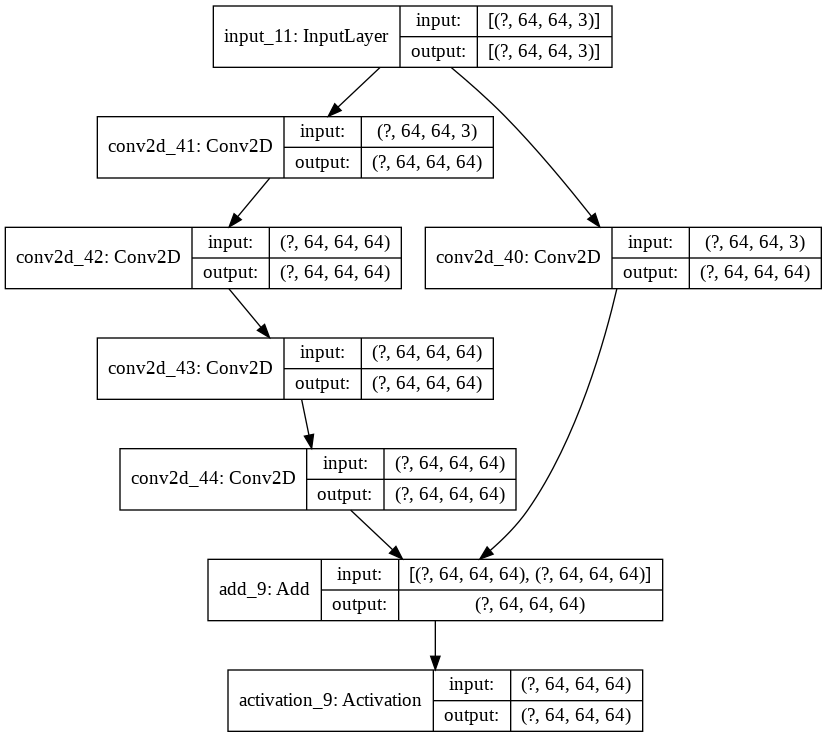

In [ ]:
def residual_module(layer_in, n_filters):
	merge_input = layer_in

	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)

	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv1)

	conv3 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(conv2)

	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv3)
	layer_out = add([conv2, merge_input])
	layer_out = Activation('relu')(layer_out)
	return layer_out

visible = Input(shape=(64, 64, 3))
layer = residual_module(visible, 64)
model = Model(inputs=visible, outputs=layer)
model.summary()
plot_model(model, show_shapes=True, to_file='residual_module.png')

Model 3: Inception Net

In [ ]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f7_in, f7_out, f4_out):
	
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	
	conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	
	conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
 
	conv7 = Conv2D(f7_in, (1,1), padding='same', activation='relu')(layer_in)
	conv7 = Conv2D(f7_out, (7,7), padding='same', activation='relu')(conv7)


	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)

	layer_out = concatenate([conv1, conv3, conv5, conv7, pool], axis=-1)
	return layer_out

visible = Input(shape=(64, 64, 3))
layer = inception_module(visible, 64, 96, 128, 16, 32, 8, 16, 32)
layer = inception_module(layer, 128, 128, 192, 32, 96, 16, 36, 64)
model = Model(inputs=visible, outputs=layer)
model.summary()
plot_model(model, show_shapes=True, to_file='inception_module.png')

In [ ]:
batch_size = 128
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

In [ ]:
model2.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

In [ ]:
model3.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))